In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import math

In [ ]:
def fun_dist(x):
    return 1 / ( 1 + math.exp(-x))

def real_data(m):
    # random distribution in (-5,5)
    x = 10*(np.random.random_sample((m,))) - 5.0 
    data = []
    for t in x:
        data.append([t, fun_dist(t)])
    return np.array(data)   


def noise_sample(m, n):
    return np.random.uniform(-5., 5., size=[m, n])

xy = real_data(200)
plt.plot(xy[:, 0], xy[:,1], 'r*')

In [ ]:
def generator(z,reuse=None):
    with tf.variable_scope('gen',reuse=reuse):
        hidden1 = tf.layers.dense(z,32,activation = tf.nn.leaky_relu)
        hidden2 = tf.layers.dense(hidden1,32, activation = tf.nn.leaky_relu)
        output_layer = tf.layers.dense(hidden2,2)
        return output_layer
    

In [ ]:
def discriminator(X,reuse=None):
    with tf.variable_scope('dis',reuse=reuse):
        hidden1 = tf.layers.dense(X, 32, activation=tf.nn.leaky_relu)
        hidden2 = tf.layers.dense(hidden1,32, activation=tf.nn.leaky_relu)
        hidden3 = tf.layers.dense(hidden2,2)
        output = tf.layers.dense(hidden3,1)
    
        return output, hidden3

In [ ]:
real_points= tf.placeholder(tf.float32, shape = [None,2])
z = tf.placeholder(tf.float32,shape = [None,2])


In [ ]:
G = generator(z)

In [ ]:
D_output_real , D_logits_real = discriminator(real_points)

In [ ]:
D_output_fake, D_logits_fake = discriminator(G,reuse=True)

In [ ]:
def loss_func(logits_in,labels_in):
    return tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=logits_in,labels=labels_in))


In [ ]:
D_real_loss = loss_func(D_logits_real,tf.ones_like(D_logits_real))

In [ ]:
D_fake_loss = loss_func(D_logits_fake,tf.zeros_like(D_logits_real))

In [ ]:
#D_loss = D_real_loss + D_fake_loss
D_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=D_logits_real,labels=tf.ones_like(D_logits_real)) + 
                       tf.nn.sigmoid_cross_entropy_with_logits(logits=D_logits_fake,labels=tf.zeros_like(D_logits_real)))

In [ ]:
G_loss = loss_func(D_logits_fake,tf.ones_like(D_logits_fake))

In [ ]:
learning_rate = 0.001

In [ ]:
tvars = tf.trainable_variables()

d_vars = [var for var in tvars if 'dis' in var.name]
g_vars = [var for var in tvars if 'gen' in var.name]

print([v.name for v in d_vars])
print([v.name for v in g_vars])

In [ ]:
D_trainer = tf.train.RMSPropOptimizer(learning_rate).minimize(D_loss, var_list=d_vars)


In [ ]:
G_trainer = tf.train.RMSPropOptimizer(learning_rate).minimize(G_loss, var_list=g_vars)

In [ ]:
samples = []

In [ ]:
# sess = tf.Session(config=config)
sess = tf.Session()
tf.global_variables_initializer().run(session=sess)
batch_num = 100
dis_steps = 10
gen_steps = 10

In [ ]:
real_data_plot = real_data(batch_num)

f = open('gen_dis_loss_logs_1.csv','w')
f.write('Iteration,Discriminator Loss,Generator Loss\n')

for i in range(10001):
    X_batch = real_data(batch_num)
    Z_batch = noise_sample(batch_num, 2)

    for _ in range(dis_steps):
        _, dis_loss = sess.run([D_trainer, D_loss], feed_dict={real_points: X_batch, z: Z_batch})
    dis_real_step, gen_fake_step = sess.run([D_logits_real,D_logits_fake], feed_dict={real_points: X_batch, z: Z_batch})
    
    for _ in range(gen_steps):
        _, gen_loss = sess.run([G_trainer, G_loss], feed_dict={z: Z_batch})
    dis_fake_step, gen_real_step = sess.run([D_logits_real, D_logits_fake], feed_dict={real_points: X_batch, z: Z_batch})

    print("Iterations: %d\t Discriminator loss: %.2f\t Generator loss: %.2f"%(i,dis_loss,gen_loss))
    
    if i%10 == 0:
        f.write("%d,%f,%f\n"%(i,dis_loss,gen_loss))

    if i%1000 == 0:
        plt.figure()
        gen_plot = sess.run(G, feed_dict={z: Z_batch})
        real_axes = plt.scatter(real_data_plot[:,0], real_data_plot[:,1])
        gen_axes = plt.scatter(gen_plot[:,0],gen_plot[:,1])

        plt.legend((real_axes,gen_axes), ("Real Data","Generated Data"))
        plt.title('Samples at Iteration %d'%i)
        plt.tight_layout()
        
        plt.savefig('sample_iteration_%d.png'%i)

        plt.close()

f.close()

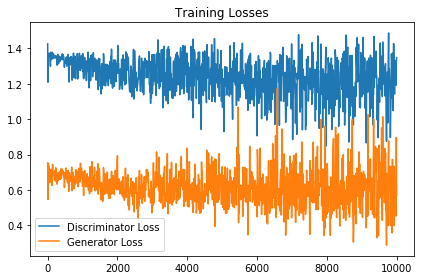

In [23]:

# data = sample_data(n=256)
#
# plt.scatter(data[:,0], data[:,1])
import pandas as pd
data = pd.read_csv('gen_dis_loss_logs_1.csv')

plt.plot('Iteration','Discriminator Loss',data=data)
plt.plot('Iteration','Generator Loss',data=data)

plt.legend()
plt.title('Training Losses')
plt.tight_layout()
plt.savefig('dataset.png')
plt.savefig('training_loss.png')
plt.show()